In [1]:
import src.get_data as get_data
import src.load_data as load
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datetime 
from dateutil import parser

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import time
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

WINDOW = 22


Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:

def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    model.summary()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [41]:
def variability(feature):
    w = 96
    
    length = int(len(feature)/w) + 1
    s = np.zeros(length)

    for j in np.arange (1,length+ 1 ):
        
        d = feature[j*w - w: j * w]

        for i in np.arange(1, d.shape[0]):
            s[j-1] += np.abs(d[i] - d[i-1])

    return s

def getViriabilityDataframe(typeBlockchain, stock):
    df = get_data.get_data_frame5minutes(typeBlockchain, stock)

    computed_variability = variability(df.volume.values) 
    variabilityDataframe= pd.DataFrame(computed_variability[1:-1].T, index= df.date.unique()[1:-1], columns=['variability'])
    variabilityDataframe.index.names = ['date']
    
    return variabilityDataframe

def computeRSI(data):
    window_length = 9
    close = data['close'] # Get just the close

    # Get the difference in price from previous step
    delta = close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous 
    # row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up1 = pd.ewma(up, window_length)
    roll_down1 = pd.ewma(down.abs(), window_length)

    # Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))
    #RSI1.index = data.date[1:]
    #RSI1 = pd.DataFrame(data = RSI1, index = data.date[1:])
    
    # Calculate the SMA
    roll_up2 = pd.rolling_mean(up, window_length)
    roll_down2 = pd.rolling_mean(down.abs(), window_length)

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    #RSI2.index = data.date[1:]
    #RSI2 = pd.DataFrame(data = RSI2, index = data.date[1:])
    return RSI1, RSI2

In [49]:
def nextDayPrediction(typeBlockchain, stock):    
    
    plot = True
    plotHictory = True
    interactiveGrapth = True
    plotForTrain = False
    
    variab = getViriabilityDataframe(typeBlockchain, stock)

    df = get_data.get_data_frame(typeBlockchain, stock)
    df.index = df.date
    RSI1, RSI2 = computeRSI(df)
    
    featurevector  = pd.concat([df.date, RSI1, RSI2, variab, df.close, df.high, df.low], axis = 1)
    featurevector.columns = ['date','RSI1', 'RSI2', 'variability', 'close', 'high', 'low']
    featurevector = featurevector.dropna()
    df = featurevector
    features = [ 'RSI1','RSI2', 'variability',  'high', 'close']
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    x = featurevector[features].copy()    
    y = featurevector['close'].copy()
    
    
    NUM_FEATURES = x.shape[1]
    
    x[features] = x_scaler.fit_transform(x)

    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
   
    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.96, TrainTest = True)
    
    model = build_model(input_shape=(WINDOW, NUM_FEATURES))
    
    print('START FIT MODEL...')
    
    start = time.time()
    
    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32, epochs=20,verbose=1,
              callbacks=[history])
    
    #model.fit(X_train, y_train, batch_size=32, epochs=500, verbose=1)
    end = time.time()

    print ('Learning time: ', end-start)
    
    today = time.strftime("_%d_%m_%Y")
    
    pathModel = "../../models/model_VarRSI_" + typeBlockchain + today +".h5"
    save_model(model, pathModel)
    
    #model = load_model(pathModel)
    # one day prediction. get last batch known data (now we didnt need in y value and can predict it)    
    lastbatch = np.array(x[-WINDOW:])
    print (lastbatch.shape)
    pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
    pred =  np.array(y_scaler.inverse_transform(pred)) # predicted value

    # now we make dataframe and create row names in date

    lastDate =str(df.date[df.last_valid_index()]).split('-')
    currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2])) + datetime.timedelta(1)
    predictionDate = pd.date_range(currentData, periods=1)
    prediction = pd.DataFrame(pred, columns=["predictionPrice"], index = predictionDate.values)

    print (prediction)
    
    
    if plotForTrain:
        
        trainPredict = model.predict(X_train)
        trainPredict = y_scaler.inverse_transform(trainPredict)
        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict
        Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
        Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
        ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
        TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

        iplot([ActualValues,TrainingValues])
        plt.show()
        
    if plot:
        trainPredict = model.predict(X_train)
        testPredict = model.predict(X_test)

        trainPredict = y_scaler.inverse_transform(trainPredict)
        trainY = y_scaler.inverse_transform([y_train])

        testPredict = y_scaler.inverse_transform(testPredict)
        testY = y_scaler.inverse_transform([y_test])

        trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
        print('Train Score: %.2f RMSE' % (trainScore))

        testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
        print('Test Score: %.2f RMSE' % (testScore))
        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

        testPredictPlot = np.empty_like(prices)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[(len(prices) - testPredict.shape[0]):len(prices), :] = testPredict

        plt.plot(pd.DataFrame(prices, columns=["close"], index=df.index).close, label='Actual')
        plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
        plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
        plt.legend(loc='best')
        plt.show()

        interactiveGrapth = 1
        if interactiveGrapth:

            Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
            Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
            Testing = pd.DataFrame(testPredictPlot, columns=["close"], index=df.date).close

            ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
            TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')
            TestingValues = go.Scatter( x = df.date, y = Testing, name = 'PredictedValues')

            iplot([ActualValues,TrainingValues, TestingValues])
            plt.show()

        if plotHictory:

            plt.plot(history.history['loss'], label = 'TrainLoss')
            plt.plot(history.history['val_loss'], label = 'TestLoss')
            plt.legend()
            plt.show()

    return prediction

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=9,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=9,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,center=False).mean()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 22, 128)           68608     
_________________________________________________________________
dropout_19 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 204,353.0
Trainable params: 204,353.0
Non-trainable params: 0.0
________________________________________________________________

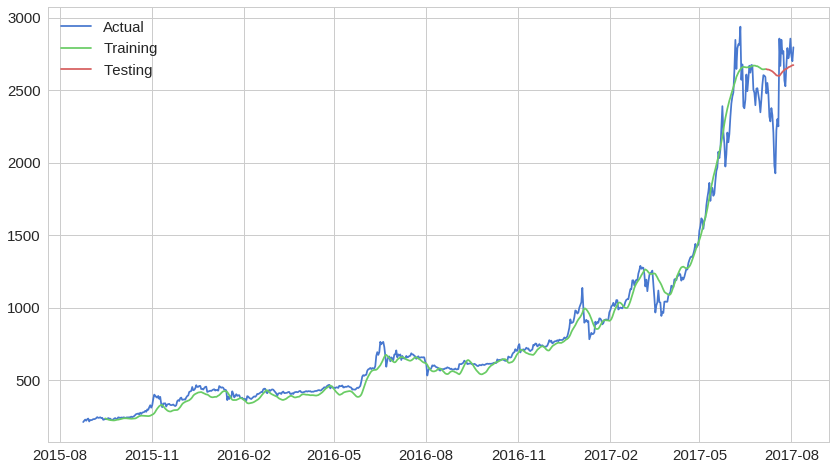

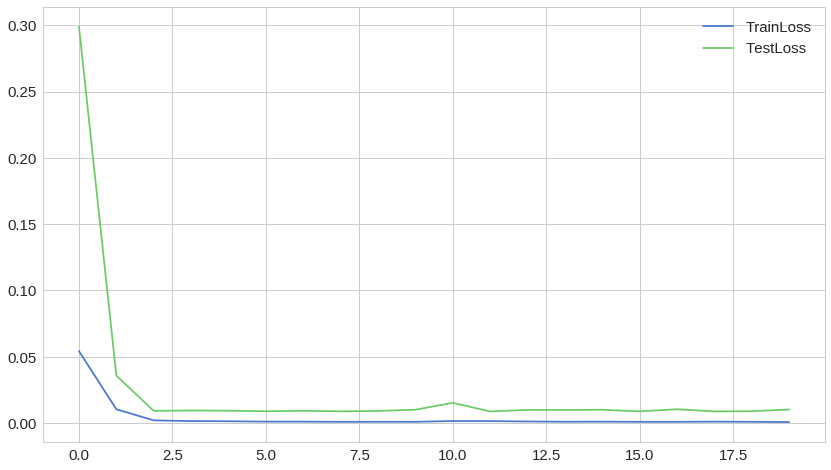

,predictionPrice
2017-08-04,2675.463867


In [50]:
nextDayPrediction('USDT_BTC', 'poloniex')


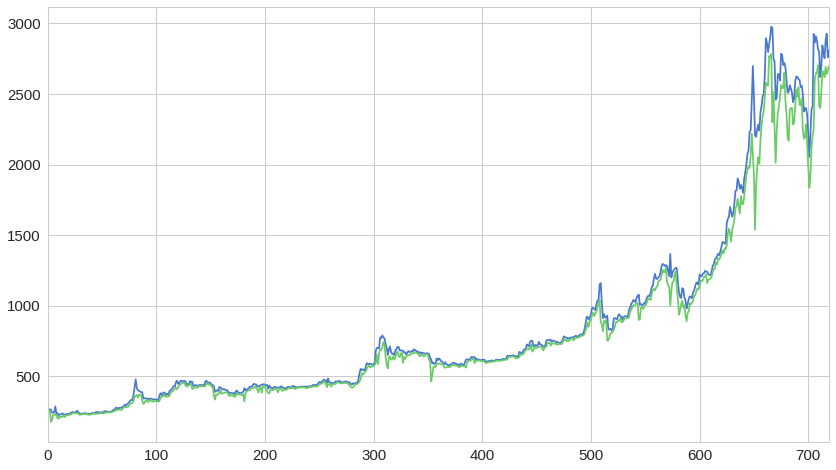

In [46]:
df = get_data.get_data_frame()

df.high.plot()
df.low.plot()
plt.show()

In [60]:

def SMA(data_frame):
    return pd.rolling_sum(data_frame, window=2)

In [76]:
def bollinger(data):
    BOLLINGER = 20

    means = pd.rolling_mean(data['close'],BOLLINGER,min_periods=BOLLINGER)
    rolling_std = pd.rolling_std(data['close'],BOLLINGER,min_periods=BOLLINGER)
    max_bol = means + rolling_std
    min_bol = means - rolling_std
    Bollinger = (data['close'] - means) / (rolling_std)
    Bollinger2 = Bollinger*Bollinger
    return Bollinger, Bollinger2

def classify(price):
    ## 2 - Buy Class, 1 - Sell Class, 0 - Hold Class
    return (2 * (price[-1] > (price[0] * 1.04)) + 1 * (price[-1] < (price[0] *0.96)))

In [77]:
Bollinger, Bollinger2 = bollinger(df)

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=20,center=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,min_periods=20,center=False).std()



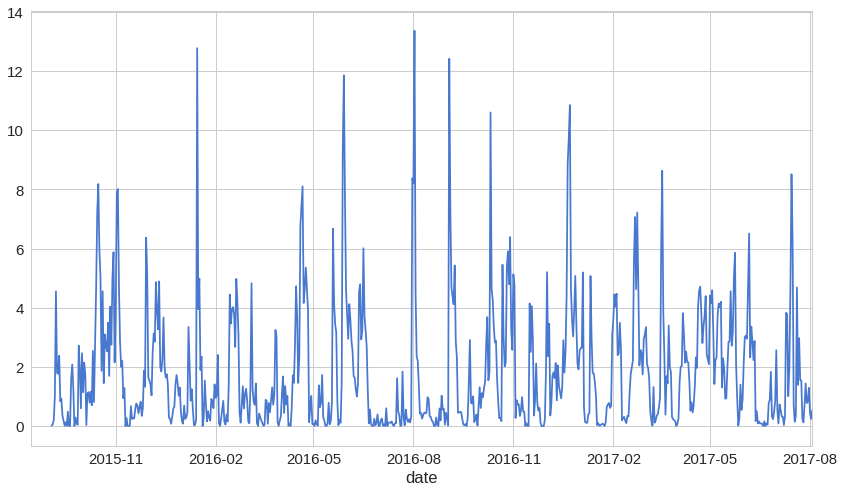

In [81]:
Bollinger2.plot()

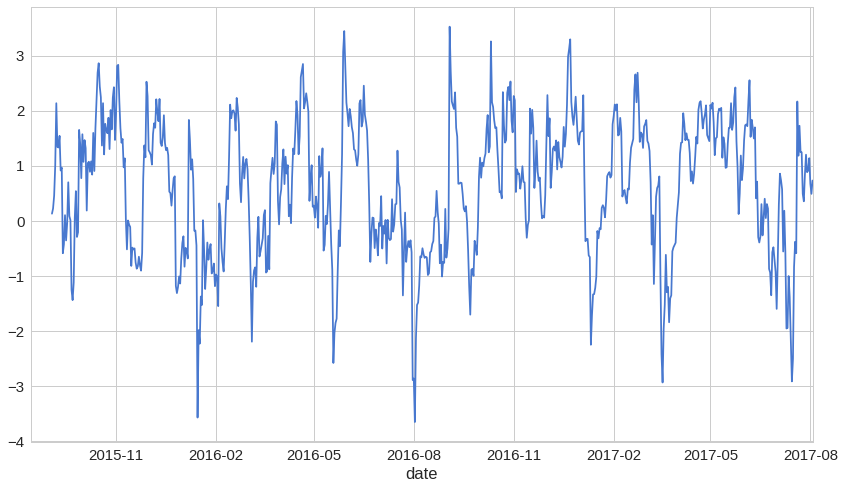

In [83]:
Bollinger.plot()